<center>
    <h1>Mohammad Jafari - 98105654</h1>
</center>

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt 

# Note
There's only one of the 3 three images included in this notebook but you can easily change the path of the loaded image so you can try other images. Also all the files **res01.jpg, res02.jpg, res03.jpg** are included in the same directory.

In [2]:
image_path = 'master-pnp-prok-01800-01833a.tif'

# Description
For simplicity, we divide this problem into several sections.
## 1. Removing the white edges
In this part, we remove the white margin of input images before starting processing. So that we can merge them easier.
## 2. Separating the Channels
By dividing the image into three different parts vertically we separate our RGB channels.
## 3. Resizing the image
Since the original image resolution is too high and checking alignments in $200\times 200$ interval takes a massive amount of time, we reduce the size of the image to $frac{1}{8}$ so we can perform our search faster and find an optimal solution in the downsized image.
## 4. Make our solution better gradually
Now that we find an optimal solution for $frac{1}{8}$ image we can now make our alignment better gradually. We already how to align the channels so if we double everything our solution remains almost the same. So we make a $frac{1}{4}$ version of the image and check and small interval($10\times 10$) around the double of the last optimal positions. Now we have another answer which is so close to the previous answer but it's even more accurate. We repeat this process until we get back to the original size image. Therefore we have a perfect full resolution alignment.
## 5. Removing the bad edges
for this part, we use Sobel kernel to define edges but before that, we apply a Gaussian Blur filter to our image. Gaussian Blur keeps image edges very well while it removes tiny and weak edges so we don't need to worry about them to distract us. So after we applied the gaussian blur filter, we use Sobel to detect remained edges. One in the vertical direction and one in the horizontal direction. Then we combine them and make a Gradient Magnitude function like that.

$$G=\sqrt{G_{x}^2 + G_{y}^2}$$

After calculating this value for all of our 3 channels we get the maximum of them and use it as a reference for edge detection. we use RGB channels because our edges are really color-sensitive.

Based on this new reference we begin to search for edges. we determine an offset above that is considered white and others are black. So we take a look at the rows and columns of the image and if more than 60 percent of them are white, we take them as an edge.
Also we limit this process to 6 percent of the image width.

##### This function removes white Edges before processing

In [3]:
def remove_edges(image):
    indexes_w = image > 180
    indexes = indexes_w

    height, width = image.shape
    percision = 0.35

    begin_h = 0
    end_h = height
    begin_w = 0
    end_w = width

    limit = int(0.1 * width)

    for i in range(limit):
        begin_h += 1
        if np.count_nonzero(indexes[:, i]) < percision * height:
            break

    for i in range(limit):
        end_h -= 1
        if np.count_nonzero(indexes[:, width - i - 1]) < percision * height:
            break

    for i in range(limit):
        begin_w += 1
        if np.count_nonzero(indexes[i, :]) < percision * width:
            break

    for i in range(limit):
        end_w -= 1
        if np.count_nonzero(indexes[height - i - 1, :]) < percision * width:
            break

    return begin_h, end_h, begin_w, end_w

##### This function removes white Edges after processing by using Sobel fliter

In [4]:
def remove_edges_by_sobel(image):
    height, width, dimension = image.shape
    gradient = apply_sobel(img=image)
    limit = int(max(0.06 * height, 0.06 * width))
    threshold = int(max(0.002 * height, 0.002 * width))
    indexes_w = gradient > 12
    precision = 0.60

    begin_height = 0
    end_height = height
    begin_width = 0
    end_width = width

    for i in range(limit):
        if np.count_nonzero(indexes_w[:, i]) > precision * height:
            begin_height = i + 1
        if np.count_nonzero(indexes_w[:, width - i - 1]) > precision * height:
            end_height = height - i - 1
        if np.count_nonzero(indexes_w[i, :]) > precision * width:
            begin_width = i + 1
        if np.count_nonzero(indexes_w[height - i - 1, :]) > precision * width:
            end_width = width - i - 1

    return begin_height + threshold, end_height - threshold, begin_width + threshold, end_width - threshold

##### This function applys a sobel filter on images after applying a gaussian blur on it

In [5]:
def apply_sobel(img, kernel_size=51):
    height, width, dimension = img.shape
    resized_img = cv2.resize(src=img, dsize=(int(width * 1/4), int(height * 1/4)), interpolation=cv2.INTER_AREA)
    current_img = apply_gaussian_blur(resized_img, kernel_size)

    sobel_kernel_horizontal = np.array([[-1, 0, 1],
                                        [-2, 0, 2],
                                        [-1, 0, 1]])
    sobel_kernel_vertical = np.array([[-1, -2, -1],
                                      [0, 0, 0],
                                      [1, 2, 1]])

    B, G, R = cv2.split(current_img)

    G_final = np.maximum.reduce([calculate_gradient_magnitude(B, sobel_kernel_horizontal, sobel_kernel_vertical),
                                 calculate_gradient_magnitude(G, sobel_kernel_horizontal, sobel_kernel_vertical),
                                 calculate_gradient_magnitude(R, sobel_kernel_horizontal, sobel_kernel_vertical)])

    return cv2.resize(src=G_final, dsize=(width, height), interpolation=cv2.INTER_AREA)

##### This function calculates Gradient Magnitude by $G_x$ and $G_y$

In [6]:
def calculate_gradient_magnitude(channel, kernel_x, kernel_y):
    Gx = cv2.filter2D(src=channel, ddepth=-1, kernel=kernel_x)
    Gy = cv2.filter2D(src=channel, ddepth=-1, kernel=kernel_y)
    return np.sqrt(Gx ** 2 + Gy ** 2)

##### This function applys a gaussian blur on input image

In [7]:
def apply_gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), cv2.BORDER_DEFAULT)

##### This function resizes the image by resize_factor

In [8]:
def resize_image(image, resize_factor: int):
    height, width = image.shape
    return cv2.resize(src=image, dsize=(int(width * resize_factor), int(height * resize_factor)),
                      interpolation=cv2.INTER_AREA)

##### This function finds best matches of 2 channels on a base channel

In [9]:
def find_best_matches(channel_A, channel_B, channel_C, threshold: int, moved_positions=((0, 0), (0, 0))):
    return find_best_match(channel_A, channel_B, threshold, moved_positions[0]), \
           find_best_match(channel_A, channel_C, threshold, moved_positions[1])

##### This function matches the channels by the input optimal opsitions

In [10]:
def create_matched_channels(channel_A, channel_B, channel_C, threshold: int, optimal_position_set):
    height, width = channel_A.shape
    b, r = optimal_position_set
    b_x, b_y = b
    r_x, r_y = r

    b_channel = np.zeros(shape=(height + 2 * threshold, width + 2 * threshold))
    g_channel = np.zeros(shape=(height + 2 * threshold, width + 2 * threshold))
    r_channel = np.zeros(shape=(height + 2 * threshold, width + 2 * threshold))

    b_channel[threshold + b_x: threshold + b_x + height, threshold + b_y: threshold + b_y + width] = channel_A[:height,
                                                                                                     :width]
    g_channel[threshold: threshold + height, threshold: threshold + width] = channel_B[:height, :width]
    r_channel[threshold + r_x: threshold + r_x + height, threshold + r_y: threshold + r_y + width] = channel_C[:height,
                                                                                                     :width]

    return b_channel, g_channel, r_channel

##### This function finds best matches of a channel on a base channel

In [11]:
def find_best_match(channel_A, channel_B, threshold_input: int, moved_positions=(0, 0)):
    height, width = channel_A.shape
    c_x, c_y = moved_positions
    threshold = max(abs(c_x) + threshold_input, abs(c_y) + threshold_input, threshold_input)

    score = np.zeros(shape=(2 * threshold_input + 1, 2 * threshold_input + 1), dtype=np.uint64)
    score = score - 1

    source_image = np.zeros(shape=(height + 2 * threshold, width + 2 * threshold))

    source_image[threshold: height + threshold, threshold: width + threshold] = channel_A[:height, :width]

    for i in range(-threshold_input, threshold_input + 1):
        for j in range(-threshold_input, threshold_input + 1):
            other_image = np.zeros(shape=(height + 2 * threshold, width + 2 * threshold))
            other_image[threshold + i + c_x: height + threshold + i + c_x,
            threshold + j + c_y: width + threshold + j + c_y] = channel_B[:height, :width]
            score[i + threshold_input, j + threshold_input] = calculate_score(source_image, other_image)

    i, j = np.unravel_index(score.argmin(), score.shape)

    return i - threshold_input + c_x, j - threshold_input + c_y

##### This function calculates the score of a match ( lower is better )

In [12]:
def calculate_score(src_img, other_img):
    return np.sum(np.abs(np.copy(src_img) - np.copy(other_img)))

## Loading image into python
Using the below code we import the required image to our program. We use **CV2** library for that.

In [13]:
# Load Image
original_image = cv2.imread(image_path, 0)
original_image = original_image.astype(np.uint16)

## Removing the white edges before processing
We remove the white edges of input image with this.

In [14]:
# Remove white edges before processing
begin_h, end_h, begin_w, end_w = remove_edges(original_image)
original_image = original_image[begin_h: end_h, begin_w:end_w]

## Seperate RGB Channels
We seperate RGB channels by dividing the image to 3 part vertically

In [15]:
# Seperate BGR Channels
original_b_channel = original_image[0:int(original_image.shape[0] / 3), :]
original_g_channel = original_image[int(original_image.shape[0] / 3):int(original_image.shape[0] / 3) * 2, :]
original_r_channel = original_image[int(original_image.shape[0] / 3) * 2:int(original_image.shape[0] / 3) * 3, :]

## Resize Image
By reducing the size of input we speed up our calculations

In [16]:
# Resize Images to smaller scale
resize_constant = 1 / 8

resized_b_channel = resize_image(image=original_b_channel, resize_factor=resize_constant)
resized_g_channel = resize_image(image=original_g_channel, resize_factor=resize_constant)
resized_r_channel = resize_image(image=original_r_channel, resize_factor=resize_constant)

## Calculate the optimal position for base image
We find the perfect alignment for resized images

In [17]:
# Calculating the optimal position in bse image
optimal_positions = ()
threshold_const = 15
optimal_positions = find_best_matches(resized_g_channel,
                                      resized_b_channel,
                                      resized_r_channel,
                                      threshold_const)

max_element = [abs(x) for optimal_set in optimal_positions for x in optimal_set]

optimized_b_channel, optimized_g_channel, optimized_r_channel = create_matched_channels(resized_b_channel,
                                                                                        resized_g_channel,
                                                                                        resized_r_channel,
                                                                                        max(max_element),
                                                                                        optimal_positions)
merged_img = cv2.merge([optimized_b_channel, optimized_g_channel, optimized_r_channel])

## The Alignment of $\frac{1}{8}$ image


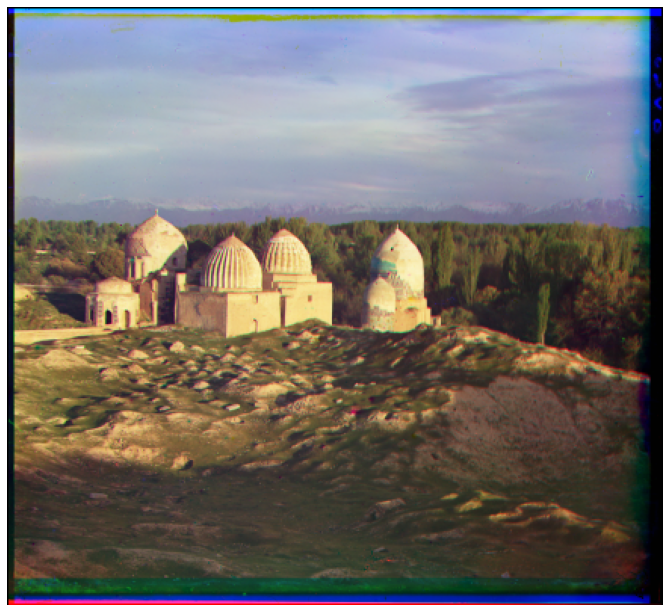

In [18]:
plt.figure(figsize=(20, 11))
plt.axis('off')
RGB_img = cv2.cvtColor(merged_img.astype(np.uint8), cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

In [19]:
# K = 1/4
resize_constant *= 2
optimal_positions = [x for optimal_set in optimal_positions for x in optimal_set]
optimal_positions = [2 * x for x in optimal_positions]
optimal_positions = tuple(tuple(optimal_positions[i:i + 2]) for i in range(0, 4, 2))


resized_b_channel = resize_image(image=original_b_channel, resize_factor=resize_constant)
resized_g_channel = resize_image(image=original_g_channel, resize_factor=resize_constant)
resized_r_channel = resize_image(image=original_r_channel, resize_factor=resize_constant)

optimal_positions = find_best_matches(resized_g_channel,
                                      resized_b_channel,
                                      resized_r_channel,
                                      4,
                                      optimal_positions)
max_element = [abs(x) for optimal_set in optimal_positions for x in optimal_set]

optimized_b_channel, optimized_g_channel, optimized_r_channel = create_matched_channels(resized_b_channel,
                                                                                        resized_g_channel,
                                                                                        resized_r_channel,
                                                                                        max(max_element),
                                                                                        optimal_positions)
merged_img = cv2.merge([optimized_b_channel, optimized_g_channel, optimized_r_channel])

## The Alignment of $\frac{1}{4}$ image

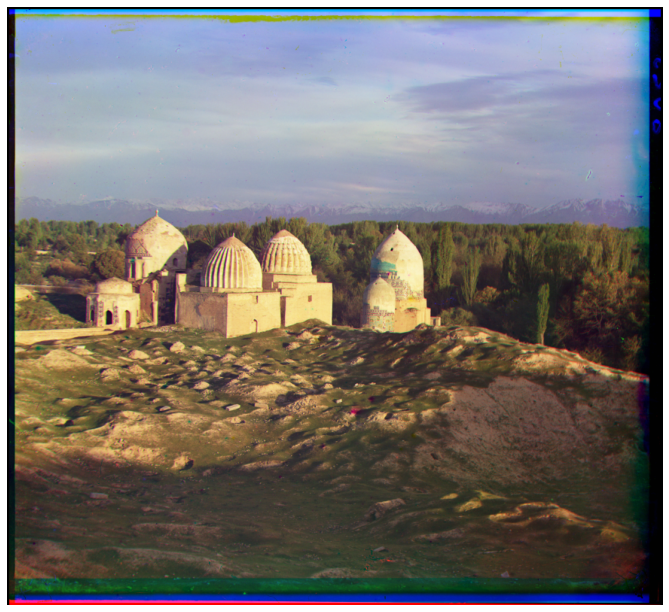

In [20]:
plt.figure(figsize=(20, 11))
plt.axis('off')
RGB_img = cv2.cvtColor(merged_img.astype(np.uint8), cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

In [21]:
# K = 1/2
resize_constant *= 2
optimal_positions = [x for optimal_set in optimal_positions for x in optimal_set]
optimal_positions = [2 * x for x in optimal_positions]
optimal_positions = tuple(tuple(optimal_positions[i:i + 2]) for i in range(0, 4, 2))


resized_b_channel = resize_image(image=original_b_channel, resize_factor=resize_constant)
resized_g_channel = resize_image(image=original_g_channel, resize_factor=resize_constant)
resized_r_channel = resize_image(image=original_r_channel, resize_factor=resize_constant)

optimal_positions = find_best_matches(resized_g_channel,
                                      resized_b_channel,
                                      resized_r_channel,
                                      4,
                                      optimal_positions)
max_element = [abs(x) for optimal_set in optimal_positions for x in optimal_set]

optimized_b_channel, optimized_g_channel, optimized_r_channel = create_matched_channels(resized_b_channel,
                                                                                        resized_g_channel,
                                                                                        resized_r_channel,
                                                                                        max(max_element),
                                                                                        optimal_positions)
merged_img = cv2.merge([optimized_b_channel, optimized_g_channel, optimized_r_channel])

## The Alignment of $\frac{1}{2}$ image

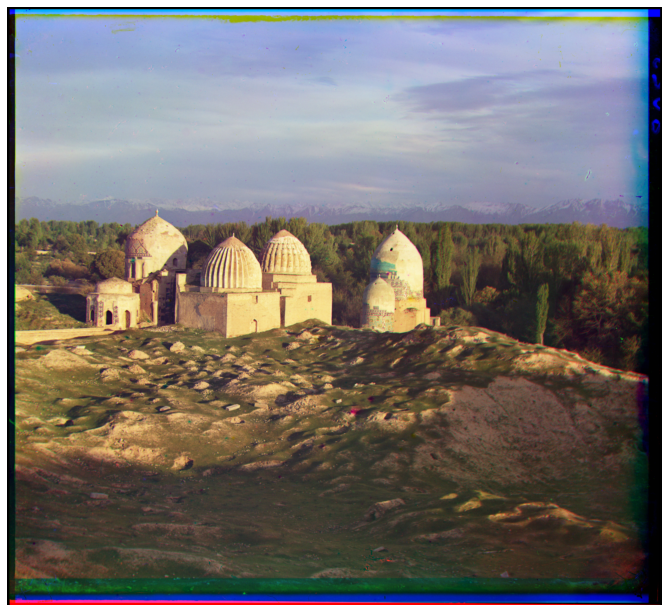

In [22]:
plt.figure(figsize=(20, 11))
plt.axis('off')
RGB_img = cv2.cvtColor(merged_img.astype(np.uint8), cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

In [23]:
# K = 1
resize_constant *= 2
optimal_positions = [x for optimal_set in optimal_positions for x in optimal_set]
optimal_positions = [2 * x for x in optimal_positions]
optimal_positions = tuple(tuple(optimal_positions[i:i + 2]) for i in range(0, 4, 2))


resized_b_channel = resize_image(image=original_b_channel, resize_factor=resize_constant)
resized_g_channel = resize_image(image=original_g_channel, resize_factor=resize_constant)
resized_r_channel = resize_image(image=original_r_channel, resize_factor=resize_constant)

optimal_positions = find_best_matches(resized_g_channel,
                                      resized_b_channel,
                                      resized_r_channel,
                                      4,
                                      optimal_positions)
max_element = [abs(x) for optimal_set in optimal_positions for x in optimal_set]

optimized_b_channel, optimized_g_channel, optimized_r_channel = create_matched_channels(resized_b_channel,
                                                                                        resized_g_channel,
                                                                                        resized_r_channel,
                                                                                        max(max_element),
                                                                                        optimal_positions)
merged_img = cv2.merge([optimized_b_channel, optimized_g_channel, optimized_r_channel])

## The Alignment of original sized image

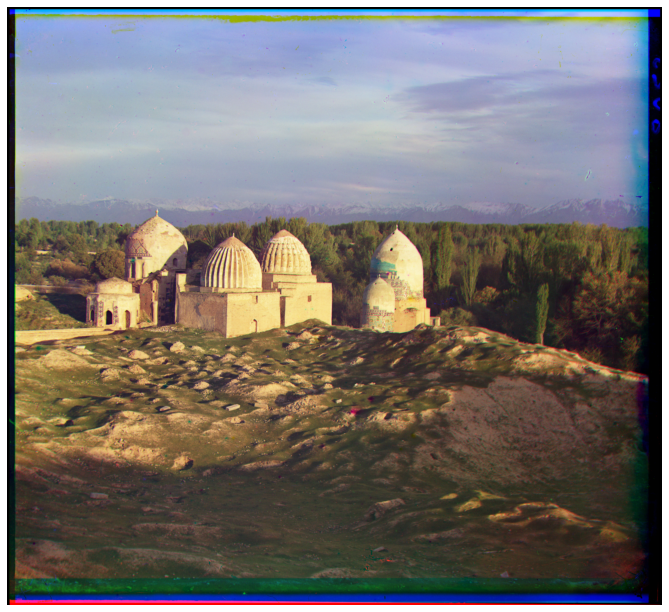

In [24]:
plt.figure(figsize=(20, 11))
plt.axis('off')
RGB_img = cv2.cvtColor(merged_img.astype(np.uint8), cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

In [25]:
begin_h, end_h, begin_w, end_w = remove_edges_by_sobel(merged_img)
merged_img = merged_img[begin_h: end_h, begin_w:end_w]

## The Alignment of original sized image with removed edges

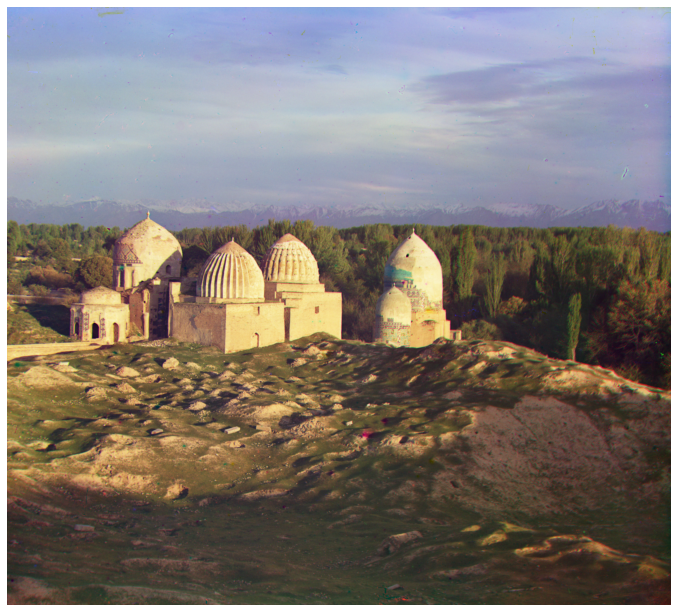

In [26]:
plt.figure(figsize=(20, 11))
plt.axis('off')
RGB_img = cv2.cvtColor(merged_img.astype(np.uint8), cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

In [27]:
cv2.imwrite('res04-Mosque.jpg', merged_img)

True